**Sppech Emotion Recognition**

Speech emotion recognition (SER) is the field of technology focused on identifying the emotional state of a speaker from their voice. This goes beyond the words spoken and analyzes how they are spoken.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Dataset Used** : Ryerson Audio-Visual Database of Emotional Speech and Son(Ravdess)


In [ ]:
dataset_path = '/content/drive/MyDrive/Ravdess all data'

About Dataset :
RAVDESS is one of the most common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders. And there's more! You can get it in song format as well. There's something for everyone and their research project. So for convenience, here's the filename identifiers as per the official RAVDESS website:


* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).

* Vocal channel (01 = speech, 02 = song).

* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).

* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.

* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").

* Repetition (01 = 1st repetition, 02 = 2nd repetition).

* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).


So, here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

This means the meta data for the audio file is:

* Video-only (02)

* Speech (01)

* Fearful (06)

* Normal intensity (01)

* Statement "dogs" (02)

* 1st Repetition (01)

* 12th Actor (12) - Female (as the actor ID number is even)


Data Augmentation to introduce irregularities

In [ ]:
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, optimizers, callbacks
from keras.models import Sequential
from keras import layers, callbacks
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report

import librosa
import os
import numpy as np
import pandas as pd
import random
import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data,rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)


In [ ]:
def calculate_mfcc(signal):
  # Computes the MFCCs of the audio signal
  mfcc = np.mean(librosa.feature.mfcc(y=signal).T, axis = 0)
  return mfcc

def calculate_zcr(signal):
  # Computes the ZCR of the audio signal
  return np.mean(librosa.feature.zero_crossing_rate(y = signal).T, axis = 0)

def calculate_rms(signal):
  # Computes the RMS value of the audio signal
  return np.mean(librosa.feature.rms(y = signal).T, axis = 0)

# Function to extract features from the audio signal
def extract_features(signal):
  res = np.array([])

  # Calculate Zero Crossing Rate
  zcr = calculate_zcr(signal)
  res = np.hstack((res, zcr))

  # Calculate Mel-Frequency Cepstral Coefficients
  mfcc = calculate_mfcc(signal)
  res = np.hstack((res, mfcc))

  # Calculate Root Mean Square Value
  rms = calculate_rms(signal)
  res = np.hstack((res, rms))

  return res

def get_features(audio_file_path):
  #loads the audio file
  signal, sr = librosa.load(audio_file_path, duration = 2.5, offset = 0.6)
  #extract features from the data without augmentation
  res1 = extract_features(signal)
  result = np.array(res1)

  #add noise and then extract the features
  noise_data = noise(signal)
  res2 = extract_features(noise_data)
  result = np.vstack((result, res2))

  #Add Stretch, pitch shift and extract the features
  new_data = stretch(signal)
  data_stretch_pitch = pitch(new_data, sr)
  res3 = extract_features(data_stretch_pitch)
  result = np.vstack((result, res3))

  return result

def prepare_data(X, Y, Y_gender, Y_emotion_gender):
  # walk through the dataset and process each file
  for path, directories, files in tqdm(os.walk(dataset_path)):
    for file in files:
      audio_file_path = os.path.join(path, file)
      features = get_features(audio_file_path)
      for element in features:
        #Append features to the lists
        X.append(element)
        #Assign emotion labels
        Y.append(emotion_dict[int(file[7:8])-1])
        gender = int(file[-6:-4])
        if (gender%2 == 0):
          #Assign genders
          Y_gender.append("Female")
          emotion_gender = emotion_dict[int(file[7:8])-1] + "_" + "Female"
        else:
          Y_gender.append("Male")
          emotion_gender = emotion_dict[int(file[7:8])-1] + "_" + "Male"
        #Assign emotion and gender labels
        Y_emotion_gender.append(emotion_gender)
  return X, Y, Y_gender, Y_emotion_gender

In [ ]:
def convert_to_dataframes(X, Y):
  #convert the features to dataframe
  Features = pd.DataFrame(X)
  #Append different labels into the dataframes
  Features['labels'] = Y
  return Features

In [ ]:
def segregate_data(df):
  #Segregate into training data
  X = df.iloc[: ,:-1].values
  #segregate into target data
  Y = df['labels'].values
  return X, Y

In [ ]:
def perform_one_hot_encoding(Y):
  #perform one hot encoding to the labels
  return encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
def split_the_data(X, Y):
  #split the data into train and test
  return train_test_split(X, Y, random_state=10, shuffle=True)

In [ ]:
def apply_fit_transform(x_train, x_test):
  # This adjusts the training data so that it has a mean of 0 and standard deviation of 1, feature-wise.
  x_train = scaler.fit_transform(x_train)
  # This ensures that the testing data is scaled using the same parameters as the training data.
  x_test = scaler.transform(x_test)
  return x_train, x_test

In [ ]:
def add_third_dimension(x_train, x_test):
  #Adding 3rd dimension to the train data
  x_train = np.expand_dims(x_train, axis=2)
  #adding 3rd dimension to the test data
  x_test = np.expand_dims(x_test, axis=2)
  return x_train, x_test

In [ ]:
def create_model_emotional(x_train):
  model=Sequential()

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(units=16, activation='relu'))
  model.add(Dropout(0.2))

  model.add(Dense(units=7, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  model.summary()
  return model

In [ ]:
def create_model_gender(x_train):
  model=Sequential()
  model.add(Conv1D(16, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(units=8, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(units=2, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

  model.summary()
  return model

In [ ]:
def create_model_emotion_gender(x_train):
  model=Sequential()
  model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

  model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.4))

  model.add(Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'))
  model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(units=16, activation='relu'))
  model.add(Dropout(0.4))

  model.add(Dense(units=14, activation='softmax'))
  model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

  model.summary()
  return model

In [ ]:
def fit_model(x_train, y_train, x_test, y_test, lr, model):
  # Initialize ReduceLROnPlateau callback
  rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=4, min_lr = lr)
  # Fit the model on the training data
  history=model.fit(x_train, y_train, batch_size=32, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp])
  return history

In [ ]:
def model_evaluation(model, x_test, y_test):
  print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

def create_graphs_for_loss_and_accuracy(history):
  epochs = [i for i in range(100)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  test_acc = history.history['val_accuracy']
  test_loss = history.history['val_loss']

  fig.set_size_inches(14,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss',marker='o', linewidth=1)
  ax[0].plot(epochs , test_loss , label = 'Testing Loss',marker='.', linewidth=1)
  ax[0].set_title('Training & Testing Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy',marker='o', linewidth=1)
  ax[1].plot(epochs , test_acc , label = 'Testing Accuracy',marker='.', linewidth=1)
  ax[1].set_title('Training & Testing Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")

  plt.show()

In [ ]:
def predict_model(model, x_test, y_test):
  pred_test = model.predict(x_test)
  y_pred = encoder.inverse_transform(pred_test)
  y_test = encoder.inverse_transform(y_test)
  return y_pred, y_test

In [ ]:
def convert_predicted_actual_to_dataframe(y_pred, y_test):
  df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
  df['Predicted Labels'] = y_pred.flatten()
  df['Actual Labels'] = y_test.flatten()
  return df

In [ ]:
def create_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize = (10, 8))
  cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
  sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=1, annot=True, fmt='')
  plt.title('Confusion Matrix', size=12)
  plt.xlabel('Predicted Labels', size=8)
  plt.ylabel('Actual Labels', size=8)
  plt.show()

0it [00:00, ?it/s]

(3240, 22) (3240, 7) (1080, 22) (1080, 7)
(3240, 22) (3240, 7) (1080, 22) (1080, 7)
(3240, 22, 1) (3240, 7) (1080, 22, 1) (1080, 7)
-------------------------------CREATING MODEL FOR PREDICTING EMOTIONS-----------------------------------------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 22, 128)           768       
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                      

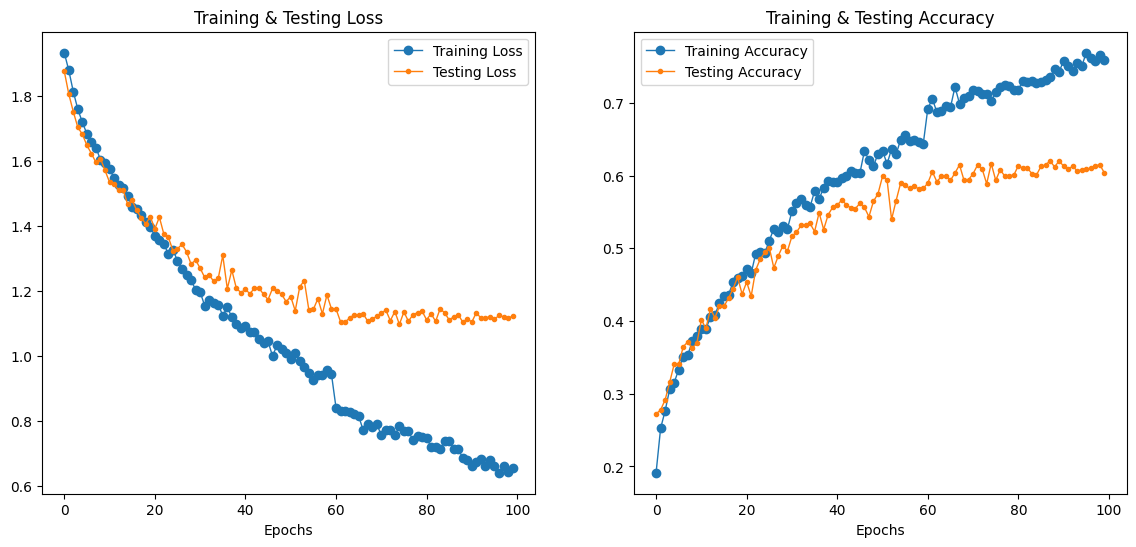

34/34 [==============================] - 0s 5ms/step


,Predicted Labels,Actual Labels
0,disgust,happy
1,happy,happy
2,surprised,happy
3,neutral,neutral
4,neutral,neutral
5,sad,sad
6,angry,angry
7,neutral,neutral
8,neutral,neutral
9,neutral,sad


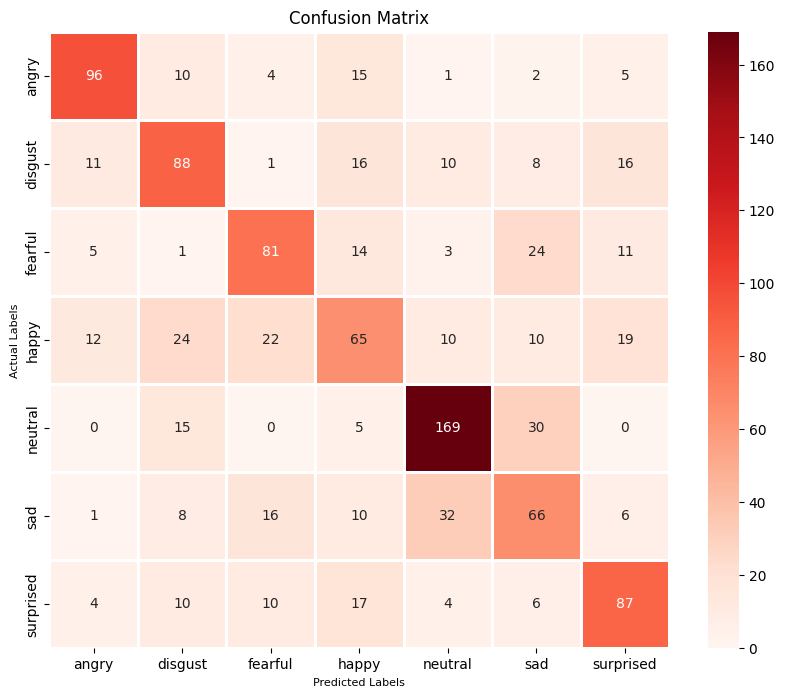

              precision    recall  f1-score   support

       angry       0.74      0.72      0.73       133
     disgust       0.56      0.59      0.58       150
     fearful       0.60      0.58      0.59       139
       happy       0.46      0.40      0.43       162
     neutral       0.74      0.77      0.75       219
         sad       0.45      0.47      0.46       139
   surprised       0.60      0.63      0.62       138

    accuracy                           0.60      1080
   macro avg       0.59      0.60      0.59      1080
weighted avg       0.60      0.60      0.60      1080

-----------------------------Adjusting Data for gender classification---------------------------------------------------------
(3240, 22) (3240, 2) (1080, 22) (1080, 2)
(3240, 22) (3240, 2) (1080, 22) (1080, 2)
(3240, 22, 1) (3240, 2) (1080, 22, 1) (1080, 2)
-------------------------------CREATING MODEL FOR PREDICTING GENDER-----------------------------------------------------------
Model: "sequentia

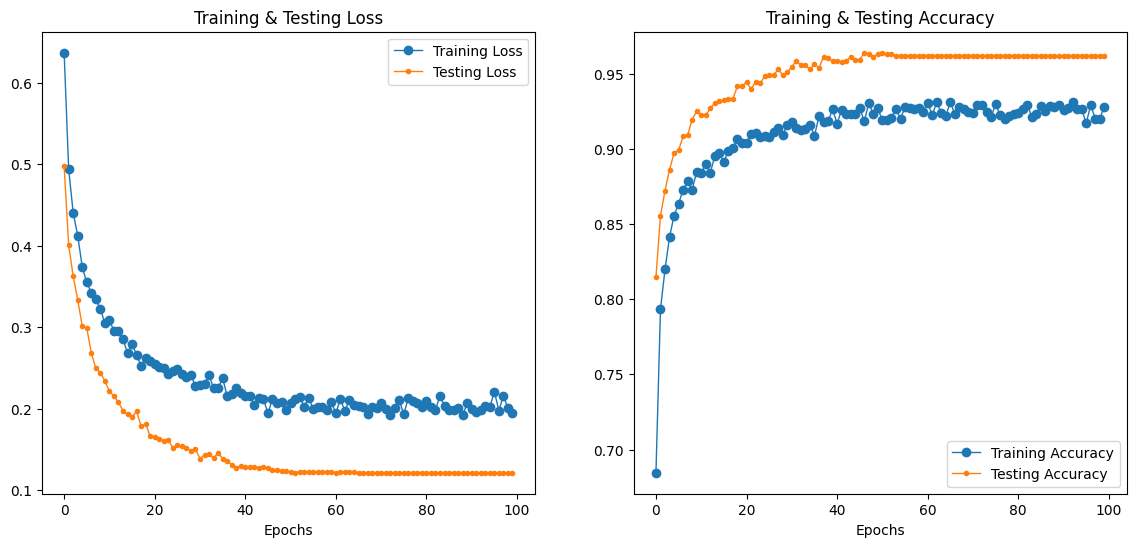

34/34 [==============================] - 0s 2ms/step


,Predicted Labels,Actual Labels
0,Male,Male
1,Male,Male
2,Male,Male
3,Male,Male
4,Female,Female
5,Male,Male
6,Male,Male
7,Male,Male
8,Female,Female
9,Female,Female


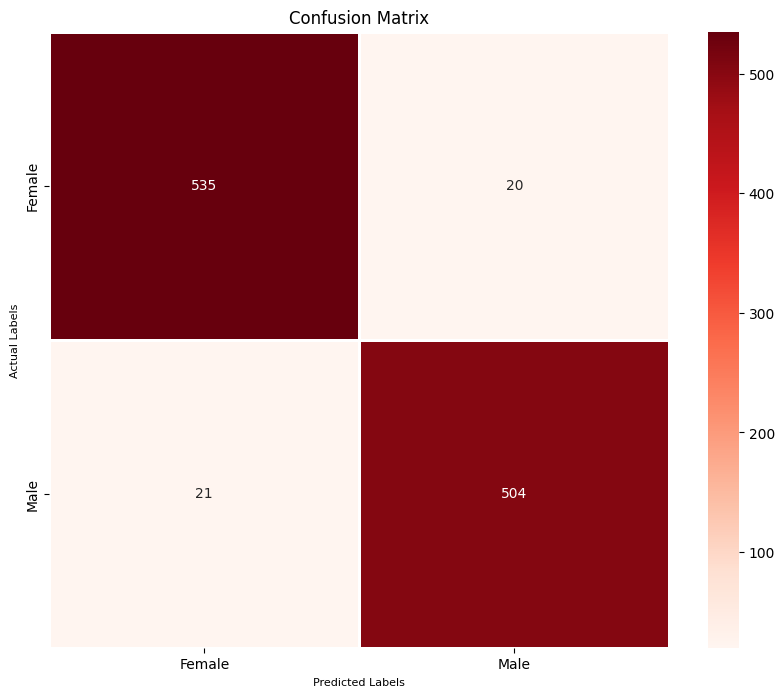

              precision    recall  f1-score   support

      Female       0.96      0.96      0.96       555
        Male       0.96      0.96      0.96       525

    accuracy                           0.96      1080
   macro avg       0.96      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080

-----------------------------Adjusting Data for gender and emotion classification together---------------------------------------------------------
(3240, 22) (3240, 14) (1080, 22) (1080, 14)
(3240, 22) (3240, 14) (1080, 22) (1080, 14)
(3240, 22, 1) (3240, 14) (1080, 22, 1) (1080, 14)
-------------------------------CREATING MODEL FOR PREDICTING GENDER AND EMOTION TOGETHER-----------------------------------------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 22, 256)           1536      
                   

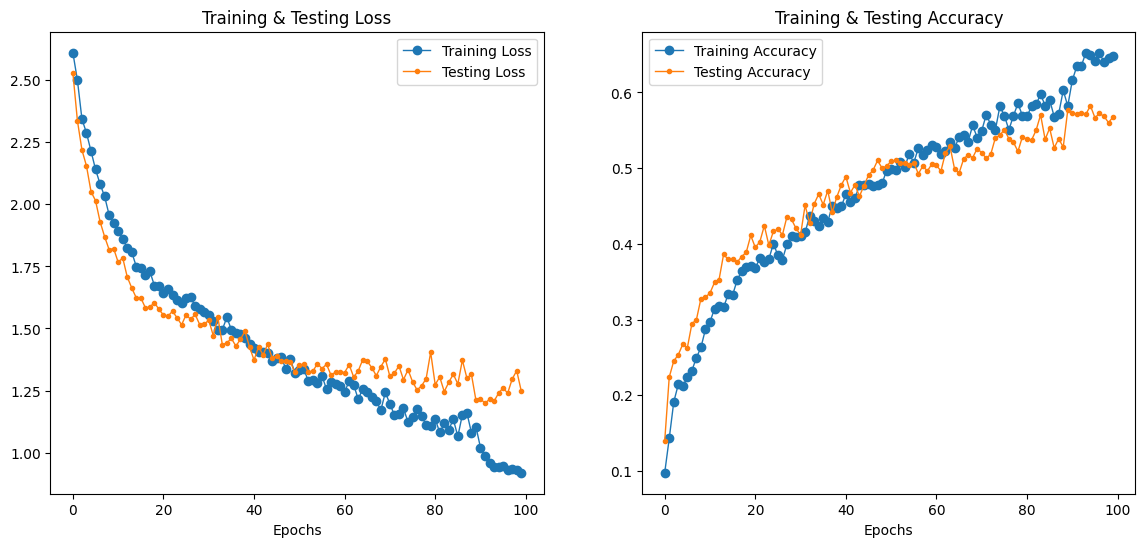

34/34 [==============================] - 0s 6ms/step


,Predicted Labels,Actual Labels
0,happy_Male,happy_Male
1,happy_Male,happy_Male
2,surprised_Male,happy_Male
3,neutral_Male,neutral_Male
4,neutral_Female,neutral_Female
5,sad_Male,sad_Male
6,happy_Male,angry_Male
7,neutral_Male,neutral_Male
8,sad_Female,neutral_Female
9,sad_Female,sad_Female


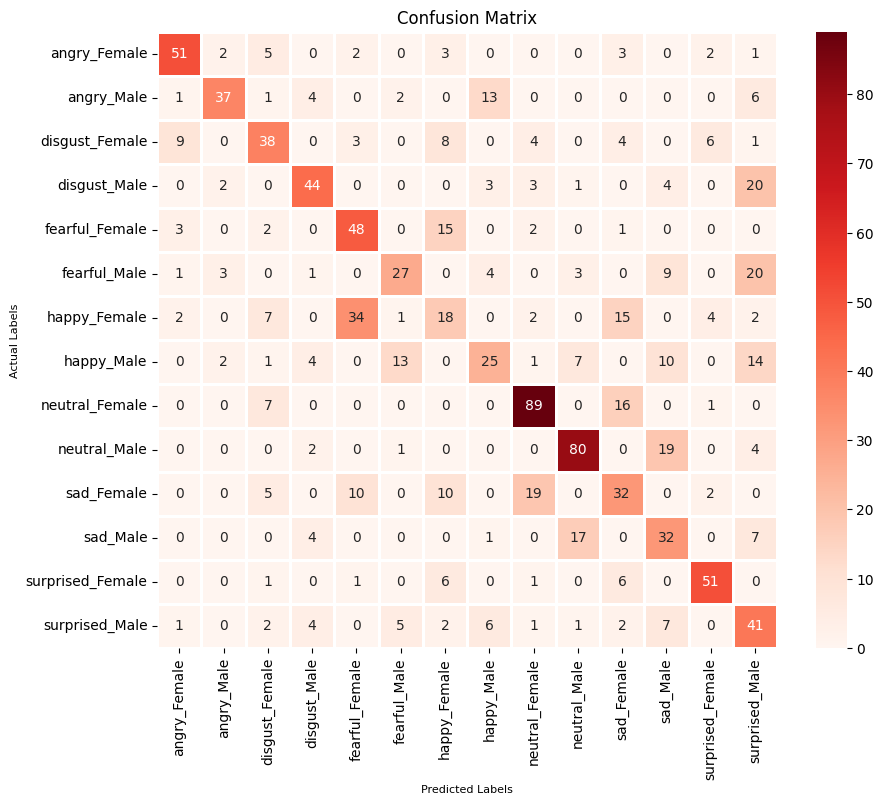

                  precision    recall  f1-score   support

    angry_Female       0.75      0.74      0.74        69
      angry_Male       0.80      0.58      0.67        64
  disgust_Female       0.55      0.52      0.54        73
    disgust_Male       0.70      0.57      0.63        77
  fearful_Female       0.49      0.68      0.57        71
    fearful_Male       0.55      0.40      0.46        68
    happy_Female       0.29      0.21      0.24        85
      happy_Male       0.48      0.32      0.39        77
  neutral_Female       0.73      0.79      0.76       113
    neutral_Male       0.73      0.75      0.74       106
      sad_Female       0.41      0.41      0.41        78
        sad_Male       0.40      0.52      0.45        61
surprised_Female       0.77      0.77      0.77        66
  surprised_Male       0.35      0.57      0.44        72

        accuracy                           0.57      1080
       macro avg       0.57      0.56      0.56      1080
    weighted

In [ ]:
if __name__ == "__main__":
  Y = []
  X = []
  Y_gender = []
  Y_emotion_gender = []
  emotion_dict = {0:'neutral', 1:'neutral', 2:'happy', 3:'sad', 4:'angry', 5:'fearful', 6:'disgust', 7:'surprised'}
  lr = 1e-6

  X, Y, Y_gender, Y_emotion_gender = prepare_data(X, Y, Y_gender, Y_emotion_gender)

  #convert data according to emotions
  Features = convert_to_dataframes(X, Y)
  Features.shape

  #segregate data according to predict emotions
  X, Y = segregate_data(Features)

  encoder = OneHotEncoder()
  #onehot encoding the data
  Y = perform_one_hot_encoding(Y)

  #Splitting the data
  x_train, x_test, y_train, y_test = split_the_data(X, Y)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  scaler = StandardScaler()
  #applying standard scaler
  x_train, x_test = apply_fit_transform(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  #Adding third dimension
  x_train, x_test = add_third_dimension(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  print("-------------------------------CREATING MODEL FOR PREDICTING EMOTIONS-----------------------------------------------------------")
  #creating emotion model
  emotion_model = create_model_emotional(x_train)

  history = fit_model(x_train, y_train, x_test, y_test, lr, emotion_model)

  #evaluate the model
  model_evaluation(emotion_model,x_test,y_test)

  #Create graph for model accuracy and loss
  create_graphs_for_loss_and_accuracy(history)

  #predict the model on the test data
  y_pred, y_test = predict_model(emotion_model, x_test, y_test)

  df = convert_predicted_actual_to_dataframe(y_pred, y_test)
  display(df.head(10))

  #creating a confusion matrix to see the predcition is more broder way
  create_confusion_matrix(y_test, y_pred)
  print(classification_report(y_test, y_pred))


  print("-----------------------------Adjusting Data for gender classification---------------------------------------------------------")

  Features.drop('labels', axis=1, inplace = True)
  Features['labels'] = Y_gender
  X, Y = segregate_data(Features)

  Y = perform_one_hot_encoding(Y)

  x_train, x_test, y_train, y_test = split_the_data(X, Y)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  x_train, x_test = apply_fit_transform(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  x_train, x_test = add_third_dimension(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  print("-------------------------------CREATING MODEL FOR PREDICTING GENDER-----------------------------------------------------------")
  #creating emotion model
  gender_model = create_model_gender(x_train)

  history = fit_model(x_train, y_train, x_test, y_test, lr, gender_model)

  #evaluate the model
  model_evaluation(gender_model,x_test,y_test)

  #Create graph for model accuracy and loss
  create_graphs_for_loss_and_accuracy(history)

  #predict the model on the test data
  y_pred, y_test = predict_model(gender_model, x_test, y_test)

  df = convert_predicted_actual_to_dataframe(y_pred, y_test)
  display(df.head(10))

  #creating a confusion matrix to see the predcition is more broder way
  create_confusion_matrix(y_test, y_pred)
  print(classification_report(y_test, y_pred))

  print("-----------------------------Adjusting Data for gender and emotion classification together---------------------------------------------------------")

  Features.drop('labels', axis=1, inplace = True)
  Features['labels'] = Y_emotion_gender
  X, Y = segregate_data(Features)

  Y = perform_one_hot_encoding(Y)

  x_train, x_test, y_train, y_test = split_the_data(X, Y)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  x_train, x_test = apply_fit_transform(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  x_train, x_test = add_third_dimension(x_train, x_test)
  print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

  print("-------------------------------CREATING MODEL FOR PREDICTING GENDER AND EMOTION TOGETHER-----------------------------------------------------------")

  #creating emotion model
  emotion_gender_model = create_model_emotion_gender(x_train)

  history = fit_model(x_train, y_train, x_test, y_test, lr, emotion_gender_model)

  #evaluate the model
  model_evaluation(emotion_gender_model,x_test,y_test)

  #Create graph for model accuracy and loss
  create_graphs_for_loss_and_accuracy(history)

  #predict the model on the test data
  y_pred, y_test = predict_model(emotion_gender_model, x_test, y_test)

  df = convert_predicted_actual_to_dataframe(y_pred, y_test)
  display(df.head(10))

  #creating a confusion matrix to see the predcition is more broder way
  create_confusion_matrix(y_test, y_pred)
  print(classification_report(y_test, y_pred))